<a href="https://colab.research.google.com/github/ffyyytt/CVPPA-ICCV23/blob/main/2023_CVPPA_ICCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import gc
import os
import cv2
import glob
import math
import yaml
import random
import logging
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tqdm.notebook import *
from sklearn.metrics import *
from sklearn.neighbors import *
from sklearn.model_selection import *

try:
    import gdown
    import keras_cv_attention_models
except:
    !pip install -qq keras-cv-attention-models
    !pip install -qq --upgrade --no-cache-dir gdown
    import keras_cv_attention_models

if not os.path.isdir("DND-Diko-WWWR"):
    !wget -qq https://phenoroam.phenorob.de/file-uploader/download/public/1769319269-DND-Diko-WWWR.zip
    !unzip -qq 1769319269-DND-Diko-WWWR.zip

if not os.path.isdir("best"):
    !gdown 1Hw00ZLefW37StUMZ15K6Er0OdRgakLDi
    !unzip -qq best.zip -d best/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.2 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1Hw00ZLefW37StUMZ15K6Er0OdRgakLDi
To: /content/best.zip
100% 2.41k/2.41k [00:00<00:00, 9.30MB/s]


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    tf.config.set_soft_device_placement(True)

    print('Running on TPU ', tpu.master())
elif len(gpus) > 0:
    strategy = tf.distribute.MirroredStrategy(gpus)
    print('Running on ', len(gpus), ' GPU(s) ')
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')

print("Number of accelerators: ", strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE

Running on CPU
Number of accelerators:  1


In [ ]:
config = {
    "seed": 1213,
    "pseudo_label": 1, # 0: false, 1: method 1, 2: method 2
    "test_path": "/content/DND-Diko-WWWR/WR2021/images/",

    "lr": 1e-5,
    "epochs": 40,
    "steps_per_epoch": 225,
    "image_size": [224, 224, 3],

    "batch_size": 8 * strategy.num_replicas_in_sync,

    "embedding_dimention": 512,

    "data": "WR2021",
    "save_path": "CVPPA/",

    "n_classes": 7,
    "label_list": ["unfertilized", "_PKCa", "N_KCa", "NP_Ca", "NPK_", "NPKCa", "NPKCa+m+s"],
    "backbones": ["swin_transformer_v2.SwinTransformerV2Tiny_ns", "EfficientNetV2S"]
}

# Data

In [ ]:
class dataGen(tf.keras.utils.Sequence):
    def __init__(self, labels, imagePaths, image_transform, pseudo_label, batch_size, test_path, shuffle = True, psd_thr = 0.9, steps = None):
        self.n = len(labels)
        self.labels = labels
        self.labels_scores = labels
        self.imagePaths = imagePaths
        self.ids = list(range(len(imagePaths)))

        self.image_transform = image_transform
        self.pseudo_label = pseudo_label
        self.batch_size = batch_size
        self.test_path = test_path
        self.shuffle = shuffle
        self.psd_thr = psd_thr
        self.steps = steps

        if (self.pseudo_label > 0):
            self.parse_prediction(f"best/{config['data']}.csv")

        if self.shuffle:
            random.shuffle(self.ids)

    def parse_prediction(self, filename):
        df = pd.read_csv(filename)

        self.labels = self.labels[:self.n]
        self.imagePaths = self.imagePaths[:self.n]

        for i in range(len(df)):
            if max(df.iloc[i, 1:].values) > self.psd_thr:
                ilabel = [0.0]*config["n_classes"]
                ilabel[np.argmax(df.iloc[i, 1:].values)] = 1.0
                self.imagePaths.append(self.test_path + df.iloc[i]["image"])
                self.labels_scores.append(df.iloc[i, 1:].values)
                self.labels.append(ilabel)
        self.ids = list(range(len(self.imagePaths)))

    def __len__(self):
        if (self.steps):
            return self.steps
        return len(self.ids) // self.batch_size + int(len(self.ids) % self.batch_size != 0)

    def read_image(self, image_path):
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = self.image_transform(image = image)["image"]
        return image

    def on_epoch_end(self):
        if (self.pseudo_label == 2) and len(glob.glob("predict_*.csv")) > 0:
            self.parse_prediction(glob.glob("predict_*.csv")[-1])
        elif (self.pseudo_label > 0):
            self.parse_prediction(f"best/{config['data']}.csv")
        if self.shuffle:
            random.shuffle(self.ids)

    def __getitem__(self, index):
        if self.steps:
            ids = random.choices(self.ids, k = self.batch_size)
        else:
            ids = self.ids[index*self.batch_size: min((index+1)*self.batch_size, len(self.ids))]

        labels_np = np.array(self.labels).astype('float32')
        labels_scores_np = np.array(self.labels_scores).astype('float32')
        images = np.array([self.read_image(self.imagePaths[i]) for i in ids])
        label = np.array([labels_np[i] for i in ids])
        label_score = np.array([labels_scores_np[i] for i in ids])

        return {"image": images, "label": label_score}, label_score

# Model

In [ ]:
class Margin(tf.keras.layers.Layer):
    def __init__(self, num_classes, margin = 0.3, scale=64, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale
        self.margin = margin
        self.num_classes = num_classes

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[0][-1], self.num_classes), initializer='random_normal', trainable=True)

    def logits_cotangent(self, feature, labels):
        cosine = self.cosine(feature)
        theta = tf.acos(tf.clip_by_value(cosine, -1, 1))
        cot = tf.math.divide_no_nan(1.0, tf.math.tan(theta))
        mr = tf.random.normal(shape = tf.shape(cosine), mean = self.margin, stddev = 0.1*self.margin)
        cot_add =  tf.math.divide_no_nan(1.0, tf.math.tan(theta + mr))
        mask = tf.cast(labels, dtype=cosine.dtype)
        logits = mask*cot_add + (1-mask)*cot
        return logits

    def cosine(self, feature):
        x = tf.nn.l2_normalize(feature, axis=-1)
        w = tf.nn.l2_normalize(self.W, axis=0)
        cos = tf.matmul(x, w)
        return cos

    def logits_cosine(self, feature, labels):
        cosine = self.cosine(feature)
        mr = tf.random.normal(shape = tf.shape(cosine), mean = self.margin, stddev = 0.1*self.margin)

        theta = tf.acos(tf.clip_by_value(cosine, -1, 1))
        cosine_add = tf.math.cos(theta + mr)

        mask = tf.cast(labels, dtype=cosine.dtype)
        logits = mask*cosine_add + (1-mask)*cosine
        return logits

    def distance(self, feature):
        x = tf.tile(tf.expand_dims(tf.nn.l2_normalize(feature, axis=-1), 2), [1, 1, self.num_classes])
        w = tf.nn.l2_normalize(tf.transpose(self.W), axis=0)
        distance = 1. / tf.math.pow(tf.clip_by_value(tf.math.sqrt( tf.reduce_sum( tf.math.pow(x-tf.transpose(w),2), axis=1)), 0.00001, 1000.0), 2 )
        return distance

    def logits_distance(self, feature, labels):
        distance= self.distance(feature)
        mr = tf.random.normal(shape = tf.shape(distance), mean = self.margin, stddev = 0.1*self.margin)
        mask = tf.cast(labels, dtype=distance.dtype)
        logits = mask*distance + (1-mask)*(distance + mr)
        return logits

    def call(self, inputs, training):
        feature, labels = inputs

        if training:
            logits = self.logits_cotangent(feature, labels) #+ self.logits_cosine(feature, labels) #+ self.logits_distance(feature, labels)
        else:
            logits = self.cosine(feature) #+ self.distance(feature)
        return logits*self.scale

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'scale': self.scale,
            'margin': self.margin,
            'num_classes': self.num_classes,
        })
        return config

In [ ]:
def get_backbone(backbone_name, x):
    if hasattr(tf.keras.applications, backbone_name):
        headModel = tf.keras.layers.Lambda(lambda data: tf.keras.applications.efficientnet_v2.preprocess_input(data))(x)
        return tf.keras.layers.GlobalAveragePooling2D()(getattr(tf.keras.applications, backbone_name)(weights = "imagenet", include_top = False)(headModel))
    else:
        backbone = getattr(getattr(keras_cv_attention_models, backbone_name.split(".")[0]), backbone_name.split(".")[1])(num_classes=0)
        headModel = tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"))(x)
        backbone.trainable = True
        if "beit" in backbone_name:
            return backbone(headModel)
        return tf.keras.layers.GlobalAveragePooling2D()(backbone(headModel))

def model_factory(backbones, embedding_dimention, n_classes):
    image = tf.keras.layers.Input(shape = (None, None, 3), dtype=tf.uint8, name = 'image')
    label = tf.keras.layers.Input(shape = (), name = 'label', dtype = tf.int32)

    features = [get_backbone(backbone, image) for backbone in backbones]
    headModel = tf.keras.layers.Concatenate()(features)
    headModel = tf.keras.layers.Dense(embedding_dimention, name = "fc_dim")(headModel)

    headModel = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name = "feature")(headModel)

    margin = Margin(num_classes = n_classes, name = "margin")([headModel, label])
    output = tf.keras.layers.Softmax(dtype=tf.float32, name = "output")(margin)

    model = tf.keras.models.Model(inputs = [image, label], outputs = [output])
    return model

# Callbacks

In [ ]:
class ValidCallback(tf.keras.callbacks.Callback):
    def __init__(self, path, train_dataset, valid_dataset, test_dataset, train_dataset_aug, valid_dataset_aug, test_dataset_aug, tta = 3):
        self.tta = tta
        self.path = path
        self.train_acc = []
        self.valid_acc = []
        self.train_losses = []
        self.valid_losses = []
        self.test_dataset = test_dataset
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

        self.test_dataset_aug = test_dataset_aug
        self.train_dataset_aug = train_dataset_aug
        self.valid_dataset_aug = valid_dataset_aug

        self.best = 0.0
        self.max_k = 3

    def plot(self):
        lepochs = range(len(self.train_losses))
        plt.plot(lepochs, self.train_losses, label='Training Loss')
        plt.plot(lepochs, self.valid_losses, label='Validation Loss')
        plt.plot(lepochs, self.train_acc, label='Training Accuracy')
        plt.plot(lepochs, self.valid_acc, label='Validation Accuracy')
        plt.legend(loc='upper left')
        plt.show()

    def knn_score(self, X_train, y_train, X_valid, y_valid, k = 3, metric = "cosine"):
        knn = KNeighborsClassifier(n_neighbors=k, metric = metric, leaf_size = 256, n_jobs = -1)
        knn.fit(X_train, y_train)
        y_pred_prob = knn.predict_proba(X_valid)
        y_pred = np.argmax(np.mean(np.split(y_pred_prob, self.tta+1), axis = 0), axis = 1)

        result = {"Accuracy": accuracy_score(y_valid, y_pred),
                  "Macro F1-Score": f1_score(y_valid, y_pred, average='macro'),
                  "Macro Precision": precision_score(y_valid, y_pred, average='macro'),
                  "Macro Recall": recall_score(y_valid, y_pred, average='macro'),
                  "Weighted Average Precision": precision_score(y_valid, y_pred, average='weighted'),
                  "Weighted Average Recall": recall_score(y_valid, y_pred, average='weighted'),
                  "Micro F1-Score": f1_score(y_valid, y_pred, average='micro')}
        cm = confusion_matrix(y_valid, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config["label_list"])
        return result, disp, classification_report(y_valid, y_pred, digits=6)

    def validation(self, train_feature, train_label, model):
        validDatas = [model.predict(self.valid_dataset)] + [model.predict(self.valid_dataset_aug) for i in range(self.tta)]
        valid_feature = np.concatenate([validData[0] for validData in validDatas], axis = 0)
        valid_label = validDatas[0][1]

        train_feature = tf.nn.l2_normalize(train_feature, axis=-1)
        valid_feature = tf.nn.l2_normalize(valid_feature, axis=-1)

        train_label = np.argmax(train_label, axis = 1)
        valid_label = np.argmax(valid_label, axis = 1)

        knn_scores = [self.knn_score(train_feature, train_label, valid_feature, valid_label, k = i, metric = "cosine") for i in trange(1, 26)] #+ [self.knn_score(train_feature, train_label, valid_feature, valid_label, k = i, metric = "euclidean") for i in trange(1, 30)]
        max_scores = max(knn_scores, key = lambda x: x[0]["Macro F1-Score"])
        print(max_scores[2])
        max_scores[1].plot()
        plt.show()
        self.max_k = knn_scores.index(max_scores) + 1
        print(f"KNN MAX F1: {max_scores[0]}, k: {self.max_k}")
        self.valid_acc.append(max_scores[0]["Accuracy"])

        if (max_scores[0]["Macro F1-Score"] > self.best):
            print(f"Save model")
            # self.model.save(os.path.join(self.path, "model.h5"), include_optimizer=False)
            self.best = max_scores[0]["Macro F1-Score"]

    def prediction(self, train_feature, train_label, model):
        testDatas = [model.predict(self.test_dataset)] + [model.predict(self.test_dataset_aug) for i in range(self.tta)]
        test_feature = np.concatenate([testData[0] for testData in testDatas], axis = 0)

        knn = KNeighborsClassifier(n_neighbors=self.max_k, metric = "cosine", leaf_size = 256, n_jobs = -1)
        train_label = np.argmax(train_label, axis = 1)

        knn.fit(train_feature, train_label)
        y_pred_prob = knn.predict_proba(test_feature)

        y_pred = np.mean(np.split(y_pred_prob, self.tta+1), axis = 0)

        df = pd.DataFrame()
        df["image"] = [v.split("/")[-1] for v in self.test_dataset.imagePaths]
        df["label"] = np.argmax(y_pred, axis = 1)

        df_full = pd.DataFrame()
        df_full["image"] = [v.split("/")[-1] for v in self.test_dataset.imagePaths]
        for i in range(len(config["label_list"])):
            df_full[config["label_list"][i]] = y_pred[:, i]

        return df, df_full

    def on_epoch_end(self, epoch, logs = {}):
        self.train_acc.append(logs["categorical_accuracy"])
        self.train_losses.append(logs["loss"])
        self.valid_losses.append(logs["val_loss"])
        model = tf.keras.models.Model(inputs = self.model.inputs,
                                      outputs = [self.model.get_layer('feature').output, self.model.inputs[1]])

        trainDatas = [model.predict(self.train_dataset)] + [model.predict(self.train_dataset_aug) for i in range(self.tta)]
        train_feature = np.concatenate([trainData[0] for trainData in trainDatas], axis = 0)
        train_label = np.concatenate([trainData[1] for trainData in trainDatas], axis = 0)
        self.validation(train_feature, train_label, model)
        gc.collect()

        # validDatas = [model.predict(self.valid_dataset)] + [model.predict(self.valid_dataset_aug) for i in range(self.tta)]
        # valid_feature = np.concatenate([validData[0] for validData in validDatas], axis = 0)
        # valid_label = np.concatenate([validData[1] for validData in validDatas], axis = 0)
        # gc.collect()

        # features = np.concatenate([train_feature, valid_feature], axis = 0)
        # labels = np.concatenate([train_label, valid_label], axis = 0)

        # df = self.evaluation(features, labels, model)
        df, df_full = self.prediction(train_feature, train_label, model)
        df.to_csv(os.path.join(self.path, f"predictions_{config['data']}_{epoch}.txt"), index = False, header = False, sep = " ")
        df_full.to_csv("pseudo.csv", index = False)

# Run

In [ ]:
def seedBasic(seed=1312):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def one_hot(x, n = config["n_classes"]):
    res = []
    for i in range(len(x)):
        r = np.zeros([n])
        r[x[i]] = 1
        res.append(r)
    return np.array(res)

seedBasic()

In [ ]:
train_transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05, rotate_limit = 20, p=0.2),

    A.LongestMaxSize(max_size=max(config["image_size"][0], config["image_size"][1]), interpolation=1),
    A.PadIfNeeded(min_height=config["image_size"][0], min_width=config["image_size"][1], border_mode=0, value=(0,0,0)),


    A.AdvancedBlur(p=0.1),
    A.RandomBrightnessContrast(p=0.2),

    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
])

valid_transform  = A.Compose([
    A.LongestMaxSize(max_size=max(config["image_size"][0], config["image_size"][1]), interpolation=1),
    A.PadIfNeeded(min_height=config["image_size"][0], min_width=config["image_size"][1], border_mode=0, value=(0,0,0)),
])

In [ ]:
#trainDatas0 = yaml.safe_load(open("DND-Diko-WWWR/WW2020/labels_trainval.yml", "r"))
trainDatas = yaml.safe_load(open(f"DND-Diko-WWWR/{config['data']}/labels_trainval.yml", "r"))

# datas = ["DND-Diko-WWWR/WW2020/images/" + i for i in trainDatas0.keys()] + ["DND-Diko-WWWR/WR2021/images/" + i for i in trainDatas1.keys()]
# labels = one_hot([config["label_list"].index(i) for i in trainDatas0.values()] + [config["label_list"].index(i) for i in trainDatas1.values()])

datas = [f"DND-Diko-WWWR/{config['data']}/images/" + i for i in trainDatas.keys()]
labels = one_hot([config["label_list"].index(i) for i in trainDatas.values()]).tolist()

trainDatas, validDatas, trainLabels, validLabels = train_test_split(datas, labels, test_size=0.2, random_state=config["seed"])
testDatas = (f"DND-Diko-WWWR/{config['data']}/images/" + pd.read_csv(f"DND-Diko-WWWR/{config['data']}/test.txt", header = None)[0].values).tolist()
testLabels = [[0]*config["n_classes"] for i in range(len(testDatas))]

In [ ]:
test_dataset = dataGen(labels = testLabels,
                       imagePaths = testDatas,
                       image_transform = valid_transform,
                       pseudo_label = 0,
                       batch_size = config["batch_size"],
                       test_path = config["test_path"],
                       shuffle = False)

valid_dataset = dataGen(labels = validLabels,
                        imagePaths = validDatas,
                        image_transform = valid_transform,
                        pseudo_label = 0,
                        batch_size = config["batch_size"],
                        test_path = config["test_path"],
                        shuffle = False)

train_dataset = dataGen(labels = trainLabels,
                        imagePaths = trainDatas,
                        image_transform = valid_transform,
                        pseudo_label = 0,
                        batch_size = config["batch_size"],
                        test_path = config["test_path"])

test_dataset_aug = dataGen(labels = testLabels,
                           imagePaths = testDatas,
                           image_transform = train_transform,
                           pseudo_label = 0,
                           batch_size = config["batch_size"],
                           test_path = config["test_path"],
                           shuffle = False)

valid_dataset_aug = dataGen(labels = validLabels,
                            imagePaths = validDatas,
                            image_transform = train_transform,
                            pseudo_label = 0,
                            batch_size = config["batch_size"],
                            test_path = config["test_path"],
                            shuffle = False)

train_dataset_aug = dataGen(labels = trainLabels,
                            imagePaths = trainDatas,
                            image_transform = train_transform,
                            pseudo_label = 0,
                            batch_size = config["batch_size"],
                            test_path = config["test_path"])

train_dataset_inf = dataGen(labels = trainLabels,
                            imagePaths = trainDatas,
                            image_transform = train_transform,
                            pseudo_label = config["pseudo_label"],
                            batch_size = config["batch_size"],
                            test_path = config["test_path"],
                            steps = config["steps_per_epoch"])

In [ ]:
with strategy.scope():
    model = model_factory(backbones = config["backbones"],
                          n_classes = config["n_classes"],
                          embedding_dimention = config["embedding_dimention"])

    optimizer = tf.keras.optimizers.Adam(learning_rate = config["lr"])

    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics =[tf.keras.metrics.CategoricalAccuracy()])

validCallback = ValidCallback(os.path.join(config["save_path"], "2021"), train_dataset, valid_dataset, test_dataset, train_dataset_aug, valid_dataset_aug, test_dataset_aug)

if os.path.isfile(os.path.join(config["save_path"], "model.h5")):
    model.load_weights(os.path.join(config["save_path"], "model.h5"))

if not os.path.isdir(config["save_path"]):
    os.makedirs(config["save_path"])

model.summary()

115588944/115588944 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_ns_224_imagenet.h5
82420632/82420632 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, None, None, 3)]      0         []                            
                                                                                                  
 lambda (Lambda)             (None, None, None, 3)        0         ['image[0][0]']               
                                                                                                  
 lambda_1 (Lambda)           (None, None, None, 3)        0         ['image[0][0]']               
                                                                     

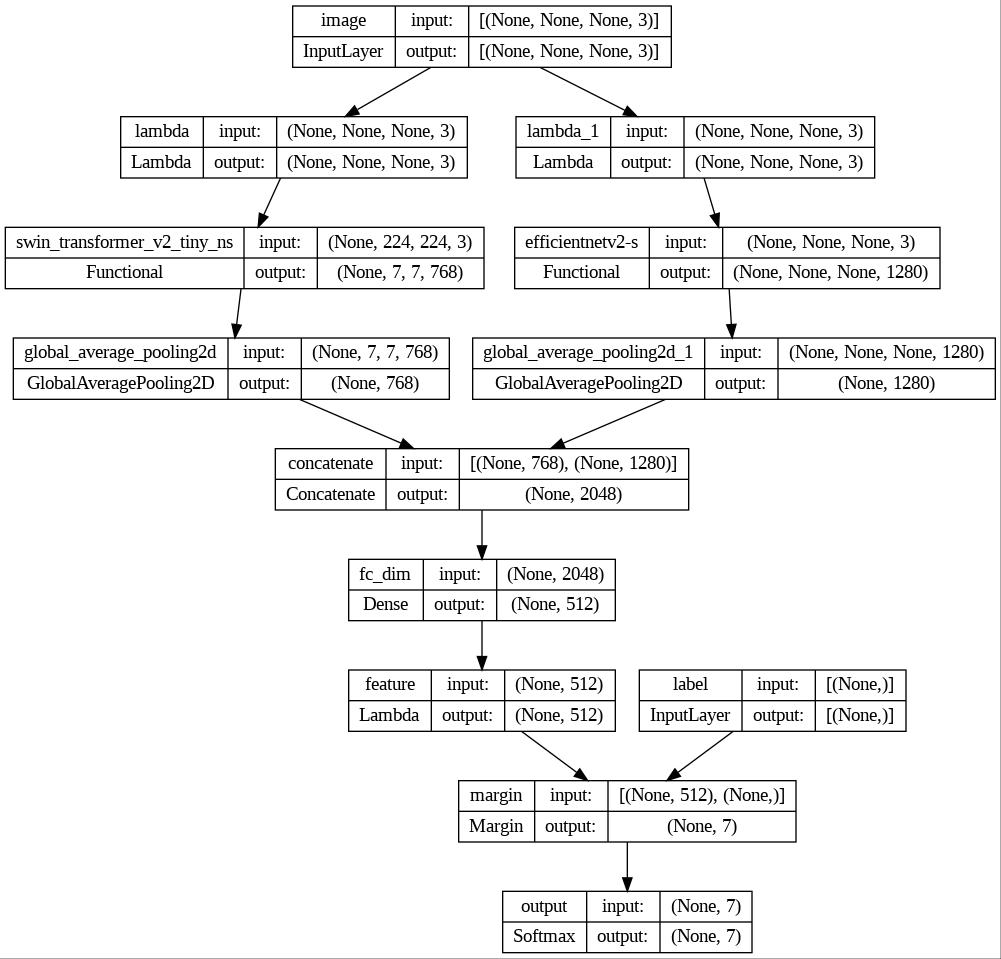

In [ ]:
tf.keras.utils.plot_model(model, to_file="model.jpg", show_shapes=True)

In [ ]:
H = model.fit(train_dataset_inf,
              validation_data = valid_dataset,
              verbose = 1,
              epochs = config["epochs"],
              callbacks = [validCallback],
              steps_per_epoch = config["steps_per_epoch"])

Epoch 1/40
 139/1000 [===>..........................] - ETA: 2:53:16 - loss: 20.0024 - categorical_accuracy: 0.0279